In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv(r'C:\Users\alexm\FX_project\2000_2024\SBUX.csv')


In [3]:
# remove date data
data2 = data.iloc[:,1:]

# create features and target
X = data2.iloc[:,:-1]
y = data2.iloc[:, 5:6]
X.head()

,Open,High,Low,Close,Adj Close
0,86.260002,86.870003,85.849998,86.589996,78.299385
1,88.000000,88.889999,87.540001,88.209999,79.764267
2,88.019997,88.790001,87.580002,88.669998,80.180222
3,89.139999,89.300003,88.430000,88.779999,80.279701
4,88.870003,88.970001,87.470001,88.129997,79.691933


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [6]:
X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_mm[:200, :]
y_test = y_mm[200:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [7]:
from torch.autograd import Variable

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors.shape[0]

200

In [8]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [9]:
# create the model
# https://cnvrg.io/pytorch-lstm/

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length): # initialise the class
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes attribute
        self.num_layers = num_layers #number of layers attribute
        self.input_size = input_size #input size attribute
        self.hidden_size = hidden_size #hidden state attribute
        self.seq_length = seq_length #sequence length attribute

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # LSTM function definition
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1 function definition
        self.fc = nn.Linear(128, num_classes) #fully connected last layer function definition
        self.relu = nn.LeakyReLU(negative_slope=0.3) # define activation
    
    def forward(self,x): # specify the forward propogation of the class (note this is overriding the forward function of the
    # nn.Module class as required by the nn.module class this is inheriting from). x is the dataset input.
        
        # instantiate the internal states of the LSTM module with zeros
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # create the hidden state of the LSTM,
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # create the internal state of the LSTM
        
        # Propagate input through model
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #LSTM with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn) # activation on the LSTM cell
        out = self.fc_1(out) # 1st Dense propogation
        out = self.relu(out) # ReLU on the first dense layer
        out = self.fc(out) # Final Output. Why is there no final activation after this step?
        out = self.relu(out) # ReLU on the final dense layer
        return out
 

In [11]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) # instantiate our lstm class

In [12]:
# Define the parameters of the model
num_epochs = 1000
learning_rate = 0.001

input_size = 5 # Represents the number of features
hidden_size = 2 # Represents the number of features in hidden state
num_layers = 1 # Represents the number of stacked lstm layers

num_classes = 1 # Represents the number of output classes

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) # Optimizer chosen as Adam

In [13]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) # Forward pass on the training data
  optimizer.zero_grad() # Caluclate the gradient, manually resetting to 0
 
  loss = criterion(outputs, y_train_tensors) # Compare the output of the model with the actual via MSE loss
 
  loss.backward() # Calculate the MSE loss gradients
 
  optimizer.step() # Backprogate
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) # Print out the MSE after every 100 epochs
print("Final MSE: ", loss.item())

Epoch: 0, loss: 0.15279
Epoch: 100, loss: 0.01853
Epoch: 200, loss: 0.01706
Epoch: 300, loss: 0.01654
Epoch: 400, loss: 0.01571
Epoch: 500, loss: 0.01391
Epoch: 600, loss: 0.01230
Epoch: 700, loss: 0.01185
Epoch: 800, loss: 0.01148
Epoch: 900, loss: 0.01117
Final MSE:  0.010939559899270535


In [14]:
# visualise results

df_X_ss = ss.transform(data2.iloc[:, :-1]) # Scale input data
df_y_mm = mm.transform(data2.iloc[:, -1:]) # Scale actuals

df_X_ss = Variable(torch.Tensor(df_X_ss)) # Transform the inputs to a tensor
df_y_mm = Variable(torch.Tensor(df_y_mm)) # Transform the actuals to a tensor

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) # Reshape the tensor to match required input shape

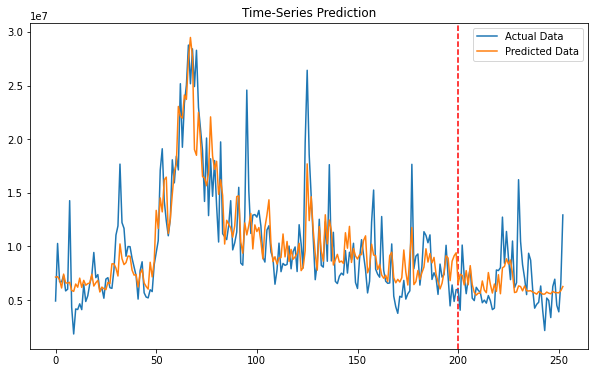

In [15]:
train_predict = lstm1(df_X_ss) # Generate predictions
data_predict = train_predict.data.numpy() # Convert predicts to numpy for charting
dataY_plot = df_y_mm.data.numpy() # Convert actuals to numpy for charting

data_predict = mm.inverse_transform(data_predict) # Reverse the scaling on the predicts
dataY_plot = mm.inverse_transform(dataY_plot) # Reverse the scaling on the actuals
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') # Separator for the training and prediction datasets

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [17]:
df_X_ss.shape

torch.Size([253, 1, 5])